In [1]:
import plotly.express as px
import pandas as pd
import geopandas as gpd
import numpy as np
import dash
import dash_core_components as dcc
import dash_html_components as html
from shapely.geometry import Point
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import folium
from IPython.display import display
from sklearn.cluster import KMeans


C:\Users\youss\AppData\Local\Temp\ipykernel_10060\2022335044.py:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
C:\Users\youss\AppData\Local\Temp\ipykernel_10060\2022335044.py:7: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


The NYPD Shooting Incident Data (Historic) dataset provides a comprehensive record of shooting incidents in New York City from 2006 through the end of the previous calendar year. Each entry represents a specific shooting event and includes detailed information about the incident, location, timing, and demographics of both victims and suspects. This dataset is manually extracted quarterly and reviewed by the Office of Management Analysis and Planning before publication.

### Key Columns in the Dataset:


**1. INCIDENT_KEY**  
A unique identifier assigned to each shooting incident.

**2. OCCUR_DATE**  
The date when the shooting occurred.

**3. OCCUR_TIME**  
The time when the shooting occurred.

**4. BORO**  
The borough where the incident took place (e.g., Manhattan, Brooklyn, Queens, The Bronx, Staten Island).

**5. PRECINCT**  
The NYPD precinct number responsible for the area where the incident occurred.

**6. JURISDICTION_CODE**  
A code indicating the jurisdiction overseeing the incident.

**7. LOCATION_DESC**  
A description of the specific location type of the incident (e.g., street, park, residence).

**8. STATISTICAL_MURDER_FLAG**  
Indicates whether the incident resulted in a homicide.

**9. PERP_AGE_GROUP**  
Age group category of the suspected perpetrator (e.g., <18, 18-24, 25-44, 45-64, 65+).

**10. PERP_SEX**  
Gender of the suspected perpetrator.

**11. PERP_RACE**  
Race of the suspected perpetrator.

**12. VIC_AGE_GROUP**  
Age group category of the victim.

**13. VIC_SEX**  
Gender of the victim.

**14. VIC_RACE**  
Race of the victim.

**15. X_COORD_CD**  
X-coordinate (longitude) of the incident location in the NAD83 coordinate system.

**16. Y_COORD_CD**  
Y-coordinate (latitude) of the incident location in the NAD83 coordinate system.

**17. Latitude**  
Geographical latitude of the incident location.

**18. Longitude**  
Geographical longitude of the incident location.



Link to Dataset: https://data.cityofnewyork.us/Public-Safety/NYPD-Shooting-Incident-Data-Historic-/833y-fsy8/data_preview

In [2]:
nyc_dataset = pd.read_csv('NYPD_Shooting_Incident_Data__Historic__20250130.csv')
nyc_dataset = nyc_dataset.drop(columns=['LOC_CLASSFCTN_DESC', 'LOC_OF_OCCUR_DESC' , 'LOCATION_DESC'], axis=0)
nyc_dataset.columns

nyc_dataset.describe()

,INCIDENT_KEY,PRECINCT,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
count,2.856200e+04,28562.000000,28560.000000,2.856200e+04,28562.000000,28503.000000,28503.000000
mean,1.274058e+08,65.496009,0.321884,1.009424e+06,208380.075755,40.738570,-73.909099
std,7.804340e+07,27.342643,0.733035,1.830111e+04,31917.509528,0.087611,0.065967
min,9.953245e+06,1.000000,0.000000,9.149281e+05,125756.718750,40.511586,-74.249303
25%,6.543991e+07,44.000000,0.000000,1.000068e+06,182912.000000,40.668648,-73.942917
50%,9.271125e+07,67.000000,0.000000,1.007772e+06,194901.390625,40.701467,-73.915068
75%,2.031320e+08,81.000000,0.000000,1.016807e+06,239814.234375,40.824878,-73.882366
max,2.797581e+08,123.000000,2.000000,1.066815e+06,271127.687500,40.910818,-73.702046


In [3]:
nyc_dataset['OCCUR_DATE'] = pd.to_datetime(nyc_dataset['OCCUR_DATE'])
nyc_dataset['OCCUR_YEAR'] = nyc_dataset['OCCUR_DATE'].dt.year
nyc_dataset['OCCUR_MONTH'] = nyc_dataset['OCCUR_DATE'].dt.strftime('%b')  
nyc_dataset['OCCUR_MONTH_NUM'] = nyc_dataset['OCCUR_DATE'].dt.month

#  Section 1: Spatial and Temporal Patterns of Shootings
We Begin by analyzing the temporal dynamics of shootings in NYC. 
The objective is to determine whether shootings exhibit seasonal patterns or if specific days of the week experience higher incidents. Key areas of focus include:
- Day of the week: Are shootings more frequent on weekends or weekdays?
- Seasonality: Do shootings increase during certain months or seasons (e.g., summer vs. winter)?
- Yearly trends: How have shooting incidents changed over time, and do they vary by borough?



### Multi Graph Line Graphs of Shooting Incident Trends Split by Boroughs 

In [4]:
shooting_counts = nyc_dataset.groupby(['OCCUR_YEAR', 'OCCUR_MONTH', 'OCCUR_MONTH_NUM', 'BORO']).size().reset_index(name='Count')
shooting_counts = shooting_counts.sort_values(by=['OCCUR_YEAR', 'OCCUR_MONTH_NUM'])
fig = px.line(
    shooting_counts,
    x='OCCUR_MONTH',
    y='Count',
    color='OCCUR_YEAR',
    facet_col='BORO',
    facet_col_wrap=2,
    title='NYPD Shooting Incidents by OCCUR_YEAR and Borough',
    labels={'Count': 'Number of Shootings', 'OCCUR_MONTH': 'OCCUR_MONTH'},
    category_orders={'OCCUR_MONTH': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']}
)


fig.update_layout(
    xaxis_title='OCCUR_MONTH',
    yaxis_title='Shootings Count',
    legend_title='OCCUR_YEAR',
    hovermode='x',
    template='plotly_dark'
)

fig.update_layout(
    width=1000,  
    height=600,  
    
)

fig.for_each_xaxis(lambda x: x.update(showticklabels=True))


fig.show()

To further investigate how shooting incidents change over time, we aim to analyze seasonality in greater detail. Specifically, we want to examine how shootings differ based on the day of the week, weekdays versus weekends, and the time of day.

To achieve this, we utilized heatmaps to visualize shooting patterns, allowing us to identify trends across different timeframes. Additionally, we plotted the distribution of shootings over time to capture fluctuations and highlight key patterns. This approach helps us understand when shootings are most likely to occur, providing valuable insights for law enforcement and policy interventions.

### Heatmap Graph of Shooting Counts by Hour and Day

In [5]:

nyc_dataset['OCCUR_HOUR'] = pd.to_datetime(nyc_dataset['OCCUR_TIME'], format='%H:%M:%S').dt.hour
hourly_shooting_counts = nyc_dataset['OCCUR_HOUR'].value_counts().reset_index()
hourly_shooting_counts.columns = ['OCCUR_HOUR', 'Count']
hourly_shooting_counts = hourly_shooting_counts.sort_values(by='OCCUR_HOUR')

nyc_dataset['Day_of_Week'] = nyc_dataset['OCCUR_DATE'].dt.day_name()  
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = nyc_dataset.groupby(['Day_of_Week', 'OCCUR_HOUR']).size().reset_index(name='Count')


fig7 = px.imshow(
    heatmap_data.pivot(index='OCCUR_HOUR', columns='Day_of_Week', values='Count').reindex(columns=day_order),
    labels=dict(color="Count", x="Day of Week", y="OCCUR_HOUR"),
    title="Shooting Counts by Hour of Day and Day of Week",
    color_continuous_scale="Viridis"  
)


fig7.show()

The first heatmap compares shooting incidents by hour of the day across different days of the week. The color scale represents the shooting count, where lighter yellow-green areas indicate higher shooting frequencies, while darker colors represent lower frequencies.

From the heatmap, we observe that the brightest areas (highest shooting incidents) occur between midnight and 3:00 AM, particularly on Saturdays and Sundays. This pattern aligns with late-night social activities, gang-related violence, and alcohol-fueled conflicts, as these are times when people are more likely to be out in public, intoxicated, and less visible to law enforcement. Bars, clubs, and parties contribute to the increase in violence during these late-night hours.

During Monday through Friday, shootings are more evenly distributed throughout the day, but the highest frequencies are observed between 6:00 PM and 11:00 PM. This suggests that while weekday shootings occur steadily, they are less concentrated compared to weekends, where incidents tend to be clustered within a specific timeframe (midnight to 3:00 AM).

The lowest shooting rates occur between 5:00 AM and 9:00 AM, as well as late morning to early afternoon (10:00 AM to 3:00 PM). This makes sense, as most people are either at home, at work, or in school, reducing the likelihood of violent encounters.

Overall, the heatmap reveals clear time-based patterns in gun violence, emphasizing the need for increased law enforcement presence during high-risk hours, particularly on weekend nights and early mornings.

### Heatmap Graph of Shooting Counts by Year and Month

In [6]:
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
nyc_dataset["OCCUR_MONTH"] = pd.Categorical(nyc_dataset["OCCUR_MONTH"], categories=month_order, ordered=True)

heatmap_data_monthly = nyc_dataset.groupby(['OCCUR_YEAR', 'OCCUR_MONTH']).size().reset_index(name='Count')

heatmap_pivot = heatmap_data_monthly.pivot(index="OCCUR_YEAR", columns="OCCUR_MONTH", values="Count")


heatmap_pivot = heatmap_pivot.reindex(columns=month_order).fillna(0)




fig10 = px.imshow(
    heatmap_pivot,
    labels={"x": "Month", "y": "Year", "color": "Shooting Count"},
    x=heatmap_pivot.columns,
    y=heatmap_pivot.index,
    title="Shooting Counts by Year and Month",
    color_continuous_scale="plasma",
)


fig10.update_layout(
    yaxis=dict(
        tickmode='linear',  
        dtick=1,            
        title="Year"        
    )
)


fig10.show()

C:\Users\youss\AppData\Local\Temp\ipykernel_10060\224370665.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Key Observations & Insights
1. Summer Peaks: Highest Shootings Occur in June - August
- A clear seasonal trend emerges, where shootings consistently peak during the summer months (June - August).
- This pattern is seen across multiple years, suggesting that warmer weather contributes to an increase in violent crime.
- 	Increased outdoor activity and social interactions.
- 	Higher gang activity and retaliatory violence.
-   School being out, leading to more unsupervised youth in high-crime areas.
### Insight: Summer months are consistently the most dangerous period for gun violence, necessitating increased law enforcement presence and community-based crime prevention programs during this time.
2. Winter Lows: Lowest Shootings in November - February
- The darkest regions (indicating fewer shootings) generally appear from November to February.
- Cold weather reduces outdoor activity.
- Holiday season may shift priorities away from violent crime.
- Potentially more police presence during holidays.
### Insight: The winter season sees a natural decline in shootings, reinforcing the impact of environmental and social factors on violent crime trends.
3. Notable Spike in 2020
- The brightest yellow spot (highest shooting counts) appears in mid-2020, particularly in June-July.
- This spike is highly unusual compared to other years, likely correlating with socio-political events such as:
- The COVID-19 pandemic’s economic impact (unemployment, stress, increased tensions).
- The George Floyd protests and civil unrest, which saw shifts in police resources.
- Changes in NYPD policies, bail reforms, or law enforcement strategies during the pandemic.
### Insight: The 2020 surge in shootings highlights how external crises (pandemic, protests, economic distress) can significantly impact violent crime rates.


### Distribution of Shooting Frequency by Hour of Day

To confirm our findings, we analyze the distribution of shootings by hour of the day by plotting the frequency of incidents over time. This visualization allows us to clearly identify the timing of gun violence.

As expected, we observe that shooting incidents peak during late-night to early-morning hours, specifically between 12:00 AM and 3:00 AM. This time frame consistently shows the highest concentration of shootings across the entire dataset. The likely causes remain bar and nightclub-related altercations, gang violence, and reduced visibility due to darkness, all of which contribute to an increased likelihood of violent incidents. These insights highlight a critical window for law enforcement intervention, emphasizing that police presence should be heightened during these peak hours to mitigate violent crime.

As the day progresses, the frequency of shootings declines significantly, reaching its lowest point in the early morning and late morning hours. However, we observe a bimodal distribution, where shootings decrease around midday but begin to rise again in the evening, eventually leading back to the late-night peak. This pattern reinforces the insights from the previous visualization, confirming that gun violence follows a cyclical trend, with two distinct peaks—one in the early morning and another in the late evening.

These findings further support the need for targeted crime prevention strategies, particularly during high-risk hours, and provide actionable insights for law enforcement resource allocation.

In [7]:
fig5 = px.bar(
    hourly_shooting_counts,
    x='OCCUR_HOUR',
    y='Count',
    title='Distribution of Shootings by Hour of Day',
    labels={'Count': 'Frequency', 'Hour': 'Hour of Day'},
    template='plotly_dark'
)
fig5.show()

### Animated Graph of Shootings over time by Borough (Interactive)

In [8]:
nyc_dataset['Month_Year'] = nyc_dataset['OCCUR_DATE'].dt.strftime('%Y-%m')
boro_shooting_counts = nyc_dataset.groupby(['Month_Year', 'BORO']).size().reset_index(name='Shooting Count')
boro_shooting_counts['Month_Year'] = boro_shooting_counts['Month_Year'].astype(str)
boro_shooting_counts['Month_Year'] = pd.Categorical(boro_shooting_counts['Month_Year'], ordered=True)
boro_shooting_counts = boro_shooting_counts.sort_values('Month_Year')


fig8 = go.Figure()


boroughs = boro_shooting_counts['BORO'].unique()
for boro in boroughs:
    fig8.add_trace(go.Scatter(
        x=[],
        y=[],
        mode="lines",
        name=boro
    ))

frames = []
for i, month in enumerate(boro_shooting_counts['Month_Year'].unique()):
    frame_data = []
    filtered_data = boro_shooting_counts[boro_shooting_counts['Month_Year'] <= month]  
    
    for boro in boroughs:
        df_boro = filtered_data[filtered_data['BORO'] == boro]
        frame_data.append(go.Scatter(
            x=df_boro['Month_Year'],
            y=df_boro['Shooting Count'],
            mode="lines",
            name=boro
        ))
    
    frames.append(go.Frame(data=frame_data, name=month))



fig8.update_layout(
    title="Monthly Shooting Trends by Borough (Cumulative Animation)",
    xaxis=dict(title="Month-Year", showticklabels = True, tickfont = dict(size=8)),
    yaxis=dict(title="Number of Shootings"
               ),
    template="plotly_dark",
    sliders = [dict(
    active=0,
    currentvalue=dict(
        prefix="Month-Year: ",
        font=dict(color="white", size=12)
       ),   
       bgcolor='white',
       bordercolor="white",
       tickcolor="white", 
       activebgcolor="white",
       font=dict(color="white", size=12),
        pad={"b": 10},  
        x=0.1,  
        y=-0.3,  
        len=0.9,
                      
    steps=[dict(
        method="animate",
        args=[[month], dict(mode="immediate", frame=dict(duration=500, redraw=True), transition=dict(duration=300))],
        label=str(month)
    ) for month in boro_shooting_counts['Month_Year'].unique()]
)],
    updatemenus=[  
        dict(
            type="buttons",
            showactive=True,
            buttons=[
                dict(label="Play", method="animate", args=[None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True}]),
                dict(label="Pause", method="animate", args=[[None], {"frame": {"duration": 0, "redraw": False}, "mode": "immediate"}])
            ],
            direction="left",
            pad={"r": 10, "t": 10},
            x=0.17,  
            y=-0.2, 
            bgcolor="grey",  
            bordercolor="grey",  
            font=dict(color="white")
        )
    ]
)
fig8.update(frames=frames)


fig8.show()

The animation visualizes the fluctuation of shooting incidents across NYC boroughs over time, providing insights into patterns influenced by seasonality, law enforcement efforts, socio-economic changes, and policy interventions.

From the animation, we observe a clear seasonality trend, with shootings consistently peaking during the warmer months, particularly from June to August. This aligns with criminological theories suggesting that crime tends to rise in warmer months, as increased outdoor activity and social interactions create more opportunities for violence.

**However, two key patterns stand out:**

1. The Bronx and Brooklyn Consistently Have the Highest Shooting Incidents
    - These boroughs repeatedly report the highest numbers of shootings, indicating they are relatively more dangerous compared to other boroughs in this dataset.
    - This suggests that targeted crime prevention and law enforcement efforts should be prioritized in these areas.

2. The COVID-19 Pandemic Triggered a Sharp Increase in Shootings

    The animation reveals a dramatic spike in shootings during the pandemic, which is a concerning anomaly in the dataset.
    This rise could be attributed to multiple factors, including:
    Reduced police presence due to officers being sick or unable to work.
    Policy changes, such as vaccine mandates, which may have decreased the number of active officers patrolling high-crime areas.
    Economic hardship and social instability caused by lockdowns, leading to increased tensions and criminal activity.
    
These findings emphasize the importance of understanding both seasonal crime patterns and external factors like public health crises when analyzing shooting trends in NYC. Addressing these issues requires a combination of targeted law enforcement, community-based intervention programs, and policy adjustments to ensure sustained reductions in gun violence.

# Section 2: Demographic Analysis of  Victims and Perpetrators
Understanding the demographics of both victims and perpetrators is crucial in assessing the underlying factors contributing to gun violence. The dataset includes key attributes such as age, race, and gender. This analysis aims to uncover disparities in shooting incidents and identify at-risk groups.

A fundamental assumption we made in this study is that the dataset is not normally distributed. This is due to potential data omissions, such as sensitive cases that law enforcement agencies may exclude for security reasons. Additionally, data collection inconsistencies can impact the overall representation of incidents. In many cases, small sample sizes or imbalanced groups (e.g., murder vs. non-murder shootings) can distort the applicability of normality assumptions. Bootstrapping is robust to outliers and does not assume a specific distribution, making it a better fit for this type of analysis. Finally, Count data (proportions, frequencies) often follows a binomial or Poisson-like distribution, not a normal distribution.
To account for these limitations, nonparametric techniques such as bootstrapping are applied. Using a random sample of 5,000 units, we estimate differences in proportions between various demographic groups, allowing for more robust inferences about trends in age and racial disparities. We speak more of bootstrapping in the latter parts of this sections where we move to R Briefly

We focus on 2 Questions: 

- On Average What is the proportion of victims of the Race = Black in NYC? 
- On Average What is the estimated difference in proportions between non-muder and murder resulting shooting incidents in NYC?


### Distribution of Victims by Age and Race

In [9]:
age_mapping = ['<18', '18-24', '25-44', '45-64', '65+']
vic_sus_filtered = nyc_dataset[nyc_dataset['VIC_AGE_GROUP'].isin(age_mapping) & nyc_dataset['PERP_AGE_GROUP'].isin(age_mapping)]

victim_race_counts = vic_sus_filtered.groupby(['VIC_RACE', 'VIC_AGE_GROUP']).size().reset_index(name='Count')



fig1 = px.bar(
    victim_race_counts,
    x='VIC_AGE_GROUP',
    y='Count',
    color='VIC_RACE',
    title='Distribution of Victims by Age Group and Race',
    labels={'Count': 'Frequency', 'VIC_AGE_GROUP': 'Age Group', 'VIC_RACE': 'Race'},
    template='plotly_dark',
    barmode='group',  
    category_orders={'VIC_AGE_GROUP': ['<18', '18-24', '25-44', '45-64', '65+']}  
)

fig1.show()

### Distribution of Perpetrators by Age and Race

In [10]:
perp_race_counts = vic_sus_filtered.groupby(['PERP_RACE', 'PERP_AGE_GROUP']).size().reset_index(name='Count')



fig2 = px.bar(
    perp_race_counts,
    x='PERP_AGE_GROUP',
    y='Count',
    color='PERP_RACE',
    title='Distribution of Perpetrators by Age Group and Race',
    labels={'Count': 'Frequency', 'PERP_AGE_GROUP': 'Age Group', 'PERP_RACE': 'Race'},
    template='plotly_dark',
    barmode='group',  
    category_orders={'PERP_AGE_GROUP': ['<18', '18-24', '25-44', '45-64', '65+']}  
)

fig2.show()


Preliminary analysis indicates that young Black and Hispanic males (ages 18-35) are disproportionately affected, both as victims and perpetrators. These findings highlight the need for community-based intervention programs targeting high-risk groups.

### Distribution of Victims By Age and Sex Categories

In [11]:
age_mapping = ['<18', '18-24', '25-44', '45-64', '65+']

victim_sex_counts = vic_sus_filtered.groupby(['VIC_SEX', 'VIC_AGE_GROUP']).size().reset_index(name='Count')



fig3 = px.bar(
    victim_sex_counts,
    x='VIC_AGE_GROUP',
    y='Count',
    color='VIC_SEX',
    title='Distribution of Victims by Age Group and Sex',
    labels={'Count': 'Frequency', 'VIC_AGE_GROUP': 'Age Group', 'VIC_SEX': 'Sex'},
    template='plotly_dark',
    barmode='group',  
    category_orders={'VIC_AGE_GROUP': ['<18', '18-24', '25-44', '45-64', '65+']}  
)

fig3.show()

### Distribution of Perpetrators By Age and Sex Categories

In [12]:
age_mapping = ['<18', '18-24', '25-44', '45-64', '65+']

perp_sex_counts = vic_sus_filtered.groupby(['PERP_SEX', 'PERP_AGE_GROUP']).size().reset_index(name='Count')



fig4 = px.bar(
    perp_sex_counts,
    x='PERP_AGE_GROUP',
    y='Count',
    color='PERP_SEX',
    title='Distribution of Perpetrators by Age Group and Sex',
    labels={'Count': 'Frequency', 'PERP_AGE_GROUP': 'Age Group', 'PERP_SEX': 'Sex'},
    template='plotly_dark',
    barmode='group',  
    category_orders={'PERP_AGE_GROUP': ['<18', '18-24', '25-44', '45-64', '65+']}  
)

fig4.show()

Young males (ages 18-44) are disproportionately involved in NYC shootings, both as victims and perpetrators, emphasizing the need for targeted intervention strategies.

### Statsitcal Inference 

After conducting some perliminary analysis on the demographic data, we utulize R to conduct statsitcal inference mainly trying to 

- Understand the proportion of victims of Race = Black involved as shooting victimes 
- Estimating the difference between proportions  of shootings that results in no murder vs murder

The analysis can be found in the repo within the R HTML File here: 

https://youssefabdelwahab.github.io/NYC_Shootings_Analysis/NYC_Inferences.html


# Section 3: Geographical Analysis of NYC Shootings

This section focuses on the spatial distribution of shooting incidents across New York City boroughs. The goal is to identify which areas are more prone to gun violence and whether specific neighborhoods exhibit higher crime rates. To achieve this, we plot incident locations by Lat and Long codes to try to create a visual of where shootings happen. Addtionally we used Principal Component Analysis (PCA) and K-Means Clustering to categorize and visualize high-risk zones based on these coordinates - more on that below. These techniques help reveal spatial patterns in shooting incidents, aiding in the identification of the most dangerous areas.


From our previous analysis, we determined that some boroughs have higher shooting occurrences than others. However, instead of analyzing shootings at the borough level alone, we want to take a closer look at specific areas within each borough to identify the most dangerous locations. By examining which parts of the boroughs experience higher shooting frequencies, we can gain deeper insights into the relationship between location and crime density, potentially uncovering patterns or factors contributing to these incidents.

Therefore the Questions we are trying to answer is 

- Which areas could be classified as more Dangerous than Others? 
- What areas in the boroughs exhibit a higher concetration of shooting incidents? 

### Maping of Shooting Incidents (Interactive)

In [13]:
df_geo = nyc_dataset.dropna(subset=['BORO', 'Latitude', 'Longitude'])


boro_shooting_counts = df_geo.groupby('BORO').agg(
    Latitude=('Latitude', 'mean'),
    Longitude=('Longitude', 'mean'),
    Count=('BORO', 'count')  
).reset_index()


fig6 = px.scatter_mapbox(
    boro_shooting_counts,
    lat='Latitude',
    lon='Longitude',
    size='Count',  
    color='Count',  
    text='BORO',  
    mapbox_style="carto-darkmatter",
    title="Total Shootings by Borough",
    opacity=0.7,
    color_continuous_scale="plasma",
    size_max=50  
)


fig6.update_layout(
    mapbox=dict(
        zoom=9,  
        center={"lat": df_geo['Latitude'].mean(), "lon": df_geo['Longitude'].mean()}  
    ),
    dragmode="pan"  
)

fig6.update_traces(
    textfont=dict(color='white')  
)





fig6.show()

C:\Users\youss\AppData\Local\Temp\ipykernel_10060\3978535349.py:11: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



This visualization presents the total number of shootings across NYC boroughs, with circle size and color intensity representing shooting frequency.

The largest and most intense-colored markers indicate that Brooklyn and the Bronx experience the highest number of shooting incidents. From our previous temporal analysis, we see that historically these boroughs have had higher crime rates. On the other hand, Queens and Manhattan have shooting incidents of moderate frequency. However, this only shows the boroughs as a whole  but does not consider the concentration of shootings in each regions. Perhaps more areas have higher concentrations than others. 


### Density Maping of Shooting Incidents (Interactive)

In [14]:
nyc_dataset['Month_Year'] = nyc_dataset['OCCUR_DATE'].dt.strftime('%Y-%m')
boro_shooting_counts = nyc_dataset.groupby(['Month_Year', 'BORO']).size().reset_index(name='Shooting Count')
boro_shooting_counts['Month_Year'] = boro_shooting_counts['Month_Year'].astype(str)
boro_shooting_counts['Month_Year'] = pd.Categorical(boro_shooting_counts['Month_Year'], ordered=True)
boro_shooting_counts = boro_shooting_counts.sort_values('Month_Year')

map4x = nyc_dataset.dropna(subset=['Latitude', 'Longitude'])


lat_bins = pd.cut(map4x['Latitude'], bins=130, precision=3)  
lon_bins = pd.cut(map4x['Longitude'], bins=130, precision=3)


map4x['Lat_Binned'] = lat_bins.map(lambda x: x.mid if pd.notnull(x) else None)
map4x['Lon_Binned'] = lon_bins.map(lambda x: x.mid if pd.notnull(x) else None)


map4x_grouped = map4x.groupby(['BORO', 'Lat_Binned', 'Lon_Binned']).size().reset_index(name='Count')


map4x_grouped['Lat_Binned'] = map4x_grouped['Lat_Binned'].astype(float)
map4x_grouped['Lon_Binned'] = map4x_grouped['Lon_Binned'].astype(float)

map4x_grouped = map4x_grouped[map4x_grouped['Count'] > 0]

fig9 = px.scatter_mapbox(
    map4x_grouped,
    lat='Lat_Binned',  
    lon='Lon_Binned',
    size="Count",
    color="Count",
    animation_frame="BORO",  
    color_continuous_scale="YlOrRd",
    title="Shooting Incidents by Lat/Long Grouped per Borough",
    mapbox_style="carto-darkmatter",
    zoom=8,
    opacity=0.7, 
    height=500
)
fig9.update_layout(mapbox=dict(
    center=dict(lat=40.7, lon=-73.9),  
    zoom=9
))
fig9.update_layout(
    height=700,  
    width=800,  
    margin=dict(l=0, r=0, t=40, b=0)  
)


fig9.show()


C:\Users\youss\AppData\Local\Temp\ipykernel_10060\586859804.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\youss\AppData\Local\Temp\ipykernel_10060\586859804.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\youss\AppData\Local\Temp\ipykernel_10060\586859804.py:18: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

To understand how shootings are concentrated within each borough, I divided New York City into a uniform spatial grid using a fixed number of bins. Each shooting incident was assigned to a grid cell based on the midpoint of its latitude and longitude. Afterward, all shooting incidents within the same grid cell were grouped together. This approach allows us to analyze the density of shootings across different areas, identifying locations with higher concentrations and greater frequency of incidents.


Bronx Dense Clusters: 

- Mott Haven 
- Hunts Point 
- Tremont 

Brooklyn Dense Clusters: 

- East York 
- Brownsville 
- Flatbush 

Manhattan Dense Clusters: 

- Harlem
- Washington Heights 
- Parts of Lower Manhattan 

Queens Dense Clusters: 

- Jamaica 
- South Ozone Park 
- Far Rockaway 

Staten Island Densre Clusters: 

- Parts of the Northern Areas

### K Means Clustering of Shooting Incidents 12x12 Grid (Interactive)

In [15]:
map4x_year = nyc_dataset.dropna(subset=['Latitude', 'Longitude'])


lat_bins = pd.cut(map4x_year['Latitude'], bins=30, precision=4)  
lon_bins = pd.cut(map4x_year['Longitude'], bins=30, precision=4)


map4x_year['Lat_Binned'] = lat_bins.map(lambda x: x.mid if pd.notnull(x) else None)
map4x_year['Lon_Binned'] = lon_bins.map(lambda x: x.mid if pd.notnull(x) else None)


map4x_grouped_year = map4x_year.groupby(['BORO', 'Lat_Binned', 'Lon_Binned', 'OCCUR_YEAR']).size().reset_index(name='Count')


map4x_grouped_year['Lat_Binned'] = map4x_grouped_year['Lat_Binned'].astype(float)
map4x_grouped_year['Lon_Binned'] = map4x_grouped_year['Lon_Binned'].astype(float)



C:\Users\youss\AppData\Local\Temp\ipykernel_10060\746208660.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\youss\AppData\Local\Temp\ipykernel_10060\746208660.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\youss\AppData\Local\Temp\ipykernel_10060\746208660.py:12: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silenc

### K Means Clustering of Shooting Desnities 12x12 Grid

In [16]:



nyc_dataset_cluster = nyc_dataset
lat_min, lat_max = 40.4, 40.9
lon_min, lon_max = -74.25, -73.6
num_lat_bins = 12
num_lon_bins = 12
lat_bins = np.linspace(lat_min, lat_max, num_lat_bins + 1)
lon_bins = np.linspace(lon_min, lon_max, num_lon_bins + 1)
nyc_dataset_cluster['Lat_bin'] = pd.cut(nyc_dataset_cluster['Latitude'], bins=lat_bins, labels=False)
nyc_dataset_cluster['Lon_bin'] = pd.cut(nyc_dataset_cluster['Longitude'], bins=lon_bins, labels=False)
grid_counts = nyc_dataset_cluster.groupby(['Lat_bin', 'Lon_bin']).size().reset_index(name='Shooting_Count')
grid_coords = grid_counts[['Lat_bin', 'Lon_bin']].dropna().values
kmeans = KMeans(n_clusters=5, random_state=42 , n_init=10)
grid_counts['KMeans_Cluster'] = kmeans.fit_predict(grid_coords)


kmeans_colors = {0: "blue", 1: "green", 2: "orange", 3: "red", 4: "purple"}

import matplotlib.pyplot as plt
import folium
from IPython.display import display
kmeans_colors_folium = {0: "blue", 1: "green", 2: "orange", 3: "red", 4: "purple"}  

nyc_map = folium.Map(location=[40.75, -74.0], zoom_start=10)

for _, row in grid_counts.iterrows():
    lat_mid = lat_min + (row["Lat_bin"] / num_lat_bins) * (lat_max - lat_min)
    lon_mid = lon_min + (row["Lon_bin"] / num_lon_bins) * (lon_max - lon_min)

    folium.CircleMarker(
        location=[lat_mid, lon_mid],
        radius=6,
        color=kmeans_colors_folium.get(row["KMeans_Cluster"], "gray"),  
        fill=True,
        fill_color=kmeans_colors_folium.get(row["KMeans_Cluster"], "gray"),
        fill_opacity=0.7,
        popup=f"Cluster: {row['KMeans_Cluster']}<br>Shootings: {row['Shooting_Count']}",
    ).add_to(nyc_map)


print("Cluster Density Legend Available Just After the Map")

display(nyc_map)

Cluster Density Legend Available Just After the Map


Finally, we applied K-Means clustering to categorize areas in NYC based on their relative level of danger. Unlike the previous approach, which analyzed each spatial bin independently, K-Means considers all shooting locations collectively and groups areas with similar shooting patterns into clusters. This allows us to compare high-risk areas across the entire city rather than viewing each grid cell in isolation.

To implement this, we divided NYC into a 12×12 spatial grid, where each bin represents a small geographic area. We defined the latitude and longitude boundaries to specify the regions of interest and then assigned each shooting incident to its respective bin. After aggregating the number of shootings per bin, we applied K-Means clustering, which groups areas based on similar shooting densities rather than just displaying frequency counts. This approach helps identify patterns in crime hotspots and classify different regions based on their shooting intensity, allowing for a more data-driven understanding of spatial crime trends in NYC.


**Green**: Very Low  
**Red**: Moderate Low  
**Blue**: Moderate  
**Orange**: Moderate High  
**Purple**: Very High  



In [17]:
grid_counts.groupby('KMeans_Cluster')['Shooting_Count'].describe()


,count,mean,std,min,25%,50%,75%,max
KMeans_Cluster,,,,,,,,
0,8.0,616.375000,675.725628,11.0,305.0,334.0,608.75,2059.0
1,9.0,47.000000,70.866071,1.0,5.0,16.0,26.00,177.0
2,12.0,802.750000,1193.781930,3.0,42.5,521.5,1091.75,4272.0
3,14.0,247.714286,249.901035,1.0,25.0,209.5,362.25,728.0
4,11.0,905.181818,1289.038465,3.0,193.5,350.0,833.50,3708.0


## Model Performance

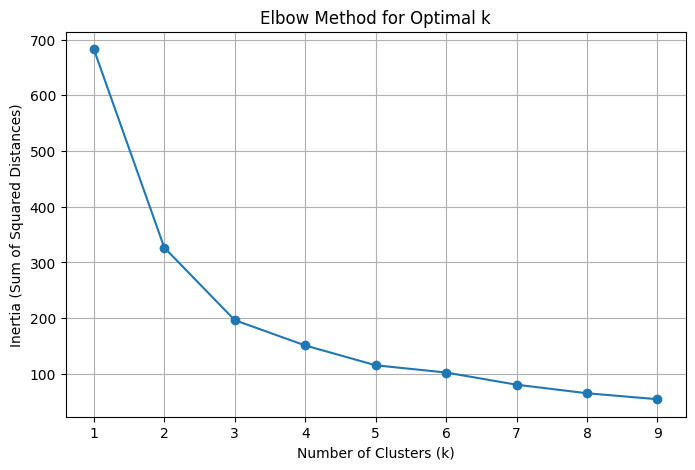

In [18]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
cluster_range = range(1, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(grid_counts[['Lat_bin', 'Lon_bin']])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal k")
plt.grid()
plt.show()